In [ ]:
# development libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Activation, BatchNormalization, Input, 
    Embedding, Dot, Dense, Flatten
)
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from wordcloud import WordCloud

import warnings
warnings.simplefilter("ignore")

# Visual Settings
%matplotlib inline
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
pd.set_option("display.float_format", lambda x:f"{x:,.4f}")

# Graphic style
plt.style.use("seaborn-v0_8")
sns.set_style("whitegrid")
sns.set_palette("Set1")

### Data loading and processing

- For the purposes of this notebook and project, we will not use these respective columns from the **anime.csv** dataset:  
*watching_status*,*watched_episodes*

In [2]:
import os
DATA_PATH = os.path.join('..', 'artifacts', 'raw')

data_rating = pd.read_csv(
    DATA_PATH+"/animelist.csv", low_memory=True, usecols=['user_id', 'anime_id', 'rating']
)

data_rating.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [3]:
data_rating.shape

(5000000, 3)

- For performance and computational economy reasons, we will only use 5 million rows from this dataset, which originally has 70 million records. For our context, this is not necessary, considering that it is a portfolio project. It should be noted that in a real scenario, it would be more appropriate to use everything we have available.

In [4]:
# checking for null values
data_rating.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [5]:
# checking for duplicate values
data_rating.duplicated().sum()

np.int64(0)

In [6]:
data_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 114.4 MB


In [7]:
data_rating.describe()

,user_id,anime_id,rating
count,"5,000,000.0000","5,000,000.0000","5,000,000.0000"
mean,"8,339.3047","16,573.6887",4.3069
std,"4,742.7587","13,795.0401",3.9070
min,0.0000,1.0000,0.0000
25%,"4,291.0000","3,297.0000",0.0000
50%,"8,378.0000","12,549.0000",6.0000
75%,"12,421.0000","30,911.0000",8.0000
max,"16,508.0000","48,491.0000",10.0000


- The **user** and **anime** columns are just identifiers; it makes no sense to perform descriptive statistical analysis on them. What interests us most is the evaluation(rating) column.

- Based on the description of the quartiles, we can say and summarize that there is a set of low scores between Quartile 1 (Q1) and Quartile 2 (median). Good to excellent scores range from the maximum limit to the maximum value.

In [8]:
# The 10 most active users.
data_rating.user_id.value_counts().head(10)

user_id
11100    14429
10255     8403
4773      5735
6852      5406
16057     5080
10409     4677
15609     4670
10665     4598
6536      4597
4132      4340
Name: count, dtype: int64

In [9]:
# The 10 most viewed anime.
data_rating.anime_id.value_counts().head(10)

anime_id
1535     11149
16498    10132
11757     9755
5114      9447
4224      9096
1575      9050
9253      8998
6547      8961
20        8352
30276     8281
Name: count, dtype: int64

The apparent relationship between the **user_id** and **anime_id** columns is many-to-many, meaning that a user may have watched one or many anime, and an anime may have been watched by one or many users.
each row in this dataset is an individual assessment

From here, we will establish a baseline and consider experienced users to be those who have rated more than 400 anime.

In [10]:
# filtering users with more ratings (experienced users)
ratings = data_rating['user_id'].value_counts()

df_rating = data_rating[data_rating['user_id'].isin(ratings[ratings >= 400].index)].copy()
df_rating.shape

(3246641, 3)

In [11]:
# obtaining the minimum, maximum, and average evaluation
min_rating = df_rating['rating'].min()
print(min_rating)

max_rating = df_rating['rating'].max()
print(max_rating)

avg_rating = df_rating['rating'].mean()
print(avg_rating)

0
10
4.122732695114736


**Min-Max Scaling Formula:**

$X_{normalized} = \frac{X - X_{min}}{X_{max} - X_{min}}$

Where:
*   $X$ is the original value of the feature.
*   $X_{min}$ is the minimum value of the feature in the dataset.
*   $X_{max}$ is the maximum value of the feature in the dataset.

**Visual Example:**

We have scores from 1 to 10:
*   Score 1 (min) would become 0.
*   Score 10 (max) would become 1.
* Grade 5 would become $(5 - 1) / (10 - 1) = 4 / 9 \approx 0.44$.

---

### Why is Normalization Important?

Normalizing data is crucial for several reasons, especially in Machine Learning projects:

1.  **Improves Algorithm Performance:** Many ML algorithms calculate distances between data points (such as K-Nearest Neighbors, Support Vector Machines) or rely on gradients (such as Neural Networks, Logistic Regression with Gradient Descent). If the features are on very different scales (e.g., ‘rating’ from 1-10 and ‘number_of_views’ from 1-1,000,000), the feature with the larger scale can dominate the distances or gradient steps, leading to suboptimal model performance.

2.  **Accelerates Convergence:** For gradient-based optimization algorithms, normalization can lead to faster convergence. Without it, the algorithm may unnecessarily “oscillate” around the minimum, as the gradients for larger-scale features will be much larger.

In [12]:
# Performing Min-Max scaling
df_rating['rating'] = df_rating['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values.astype(np.float64)

In [13]:
# measures transformed by Min-Max
min_rating = df_rating['rating'].min()
print(min_rating)

max_rating = df_rating['rating'].max()
print(max_rating)

avg_rating = df_rating['rating'].mean()
print(avg_rating)

0.0
1.0
0.4122732695114736


In [14]:
df_rating.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [15]:
df_rating.duplicated().sum()

np.int64(0)

In [16]:
# encoding and decoding users
user_ids = df_rating['user_id'].unique().tolist()

# Encoded values
user2user_encoded = {x: i for i, x in enumerate(user_ids)}

# Decoded values
user2user_decoded = {i: x for i, x in enumerate(user_ids)}

num_users = len(user2user_encoded)

In [17]:
df_rating['user'] = df_rating['user_id'].map(user2user_encoded)
df_rating.head()

,user_id,anime_id,rating,user
213,2,24833,0.0000,0
214,2,235,1.0000,0
215,2,36721,0.0000,0
216,2,40956,0.0000,0
217,2,31933,0.0000,0


In [18]:
# encoding and decoding animes
anime_ids = df_rating['anime_id'].unique().tolist()

# Encoded values
anime2anime_encoded = {x: i for i, x in enumerate(anime_ids)}

# Decoded values
anime2anime_decoded = {i: x for i, x in enumerate(anime_ids)}

num_animes = len(anime2anime_encoded)

In [19]:
df_rating['anime'] = df_rating['anime_id'].map(anime2anime_encoded)
df_rating.head()

,user_id,anime_id,rating,user,anime
213,2,24833,0.0000,0,0
214,2,235,1.0000,0,1
215,2,36721,0.0000,0,2
216,2,40956,0.0000,0,3
217,2,31933,0.0000,0,4


In [20]:
# separating into training and testing
X = df_rating[['user', 'anime']].values
y = df_rating['rating']

In [21]:
# # Train Test Splitting
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, shuffle=True, test_size=0.2
)

In [22]:
X.shape, X_train.shape, X_test.shape

((3246641, 2), (2597312, 2), (649329, 2))

In [23]:
y_train.shape, y_test.shape

((2597312,), (649329,))

In [24]:
type(X_train)

numpy.ndarray

In [25]:
X_train

array([[  27, 2700],
       [2173, 2056],
       [ 482,  197],
       ...,
       [2881, 5028],
       [3569,  175],
       [2870, 1895]], shape=(2597312, 2))

In [26]:
# # Splitting into two halves: user and anime
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

type(X_train_array), type(X_train_array[0])

(list, numpy.ndarray)

In [27]:
X_train_array

[array([  27, 2173,  482, ..., 2881, 3569, 2870], shape=(2597312,)),
 array([2700, 2056,  197, ..., 5028,  175, 1895], shape=(2597312,))]

### Model Architecture

In [28]:
def Recommender(num_users, num_animes):
    embedding_size = 128
    
    user = Input(name= 'user', shape= [1])
    user_embedding = Embedding(name= 'user_embedding', input_dim= num_users, output_dim= embedding_size)(user)


    anime = Input(name= 'anime', shape= [1])
    anime_embedding = Embedding(name= 'anime_embedding', input_dim= num_animes, output_dim= embedding_size)(anime)


    dot_product = Dot(name= 'dot_product', normalize= True, axes= 2)([user_embedding, anime_embedding])


    dot_product = Flatten()(dot_product)
    

    dot_product = Dense(1, kernel_initializer= 'he_normal')(dot_product)


    dot_product = BatchNormalization()(dot_product)


    dot_product = Activation('sigmoid')(dot_product)


    model = Model(inputs= [user, anime], outputs= dot_product)


    model.compile(loss= 'binary_crossentropy', metrics= ['mae', 'mse'], optimizer= 'Adam')

    return model

In [29]:
model = Recommender(num_users, num_animes)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    537,984 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,733,062 (10.43 MB)

 Trainable params: 2,733,060 (10.43 MB)

 Non-trainable params: 2 (8.00 B)

In [30]:
# Required values for model training

start_lr = 0.00001
min_lr = 0.0001
max_lr = 0.00005
batch_size = 10000
ram_epochs = 4
sustain_epochs = 0
exp_decay = 0.8

In [31]:
#The purpose of this function is basically to find the best learning rate for the model.

def learning_rate_fn(epoch):
    if epoch < ram_epochs:
        return (max_lr - start_lr) / ram_epochs * epoch + start_lr
    elif epoch < ram_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay ** (epoch - ram_epochs - sustain_epochs) + min_lr

In [32]:
learning_rate_callback = LearningRateScheduler(
    lambda epoch: learning_rate_fn(epoch= epoch), verbose= 0
)

checkpoint_filepath = './weights.weights.h5'


model_checkpoint = ModelCheckpoint(
    filepath= checkpoint_filepath, save_weights_only= True, 
    monitor= 'val_loss', mode= 'min', save_best_only= True
)


early_stopping = EarlyStopping(
    patience= 5, monitor= 'val_loss', 
    mode= 'min', restore_best_weights= True
)


callbacks = [model_checkpoint, learning_rate_callback, early_stopping]

In [33]:
historical = model.fit(
    x= X_train_array,
    y= y_train,
    batch_size= batch_size,
    epochs= 13,
    verbose= 1,
    validation_data= (X_test_array, y_test),
    callbacks= callbacks
)

Epoch 1/13
260/260 ━━━━━━━━━━━━━━━━━━━━ 19s 70ms/step - loss: 0.7973 - mae: 0.3815 - mse: 0.1963 - val_loss: 0.7091 - val_mae: 0.3644 - val_mse: 0.1631 - learning_rate: 1.0000e-05
Epoch 2/13
260/260 ━━━━━━━━━━━━━━━━━━━━ 18s 70ms/step - loss: 0.7940 - mae: 0.3803 - mse: 0.1950 - val_loss: 0.7657 - val_mae: 0.3757 - val_mse: 0.1857 - learning_rate: 2.0000e-05
Epoch 3/13
260/260 ━━━━━━━━━━━━━━━━━━━━ 19s 71ms/step - loss: 0.7879 - mae: 0.3779 - mse: 0.1925 - val_loss: 0.7895 - val_mae: 0.3800 - val_mse: 0.1936 - learning_rate: 3.0000e-05
Epoch 4/13
260/260 ━━━━━━━━━━━━━━━━━━━━ 19s 71ms/step - loss: 0.7790 - mae: 0.3743 - mse: 0.1889 - val_loss: 0.7890 - val_mae: 0.3798 - val_mse: 0.1933 - learning_rate: 4.0000e-05
Epoch 5/13
260/260 ━━━━━━━━━━━━━━━━━━━━ 19s 73ms/step - loss: 0.7669 - mae: 0.3694 - mse: 0.1840 - val_loss: 0.7841 - val_mae: 0.3784 - val_mse: 0.1915 - learning_rate: 5.0000e-05
Epoch 6/13
260/260 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - loss: 0.7507 - mae: 0.3624 - mse: 0.1773 - v

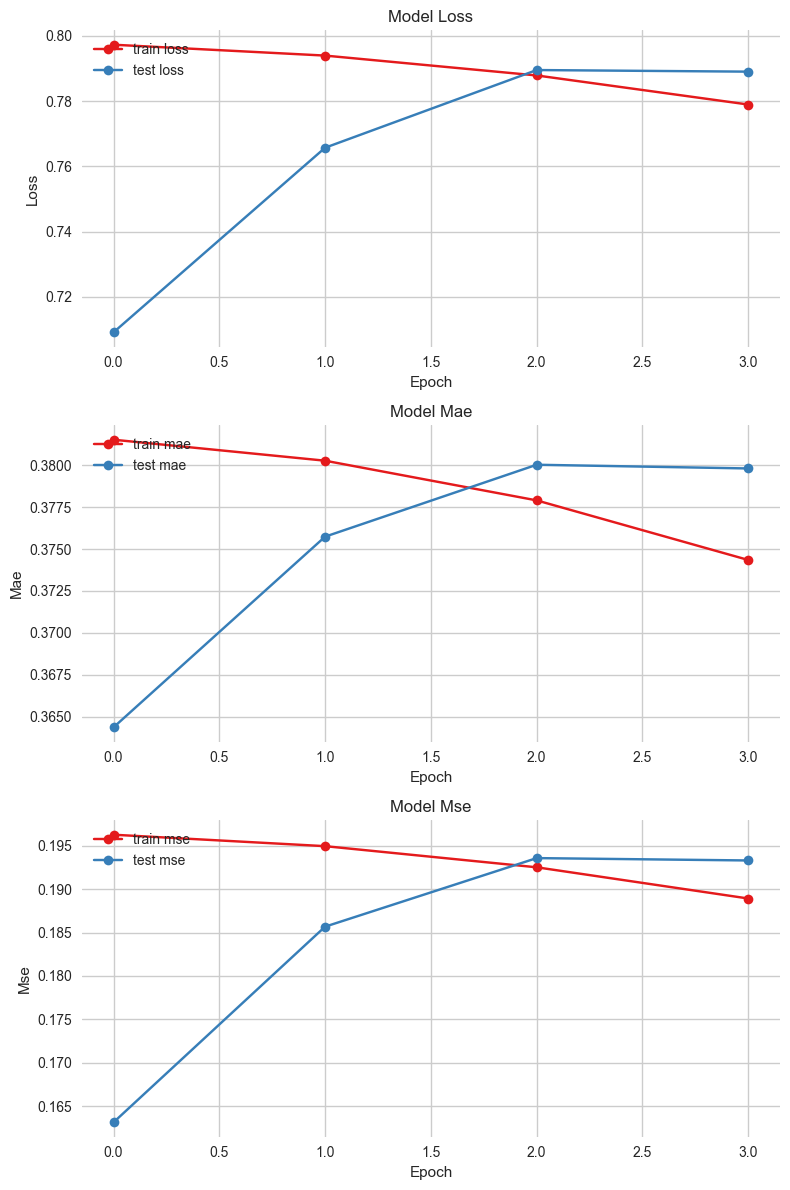

In [34]:
metrics = ["loss", "mae", "mse"]

# Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics) * 4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(historical.history[metric][0:-2], marker = "o", label = f"train {metric}")
    ax.plot(historical.history[f"val_{metric}"][0:-2], marker = "o", label = f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc = "upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [35]:
# Extracting weights 

def extract_weights(name,model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights,axis=1).reshape((-1,1))
    return weights

In [36]:
anime_weights = extract_weights("anime_embedding", model)

user_weights = extract_weights("user_embedding", model)

### Anime Dataset Loading and Processing

In [37]:
data_anime = pd.read_csv(
    DATA_PATH+"/anime.csv", low_memory=True
)

data_anime.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,Bandai Visual,"Funimation, Bandai Entertainment",Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity),28.0,39,1251960,61971,105808,718161,71513,26678,329800,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,"Sunrise, Bandai Visual",Sony Pictures Entertainment,Bones,Original,1 hr. 55 min.,R - 17+ (violence & profanity),159.0,518,273145,1174,4143,208333,1935,770,57964,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [38]:
data_anime.shape

(17562, 35)

In [39]:
data_anime.isnull().sum()

MAL_ID           0
Name             0
Score            0
Genres           0
English name     0
Japanese name    0
Type             0
Episodes         0
Aired            0
Premiered        0
Producers        0
Licensors        0
Studios          0
Source           0
Duration         0
Rating           0
Ranked           0
Popularity       0
Members          0
Favorites        0
Watching         0
Completed        0
On-Hold          0
Dropped          0
Plan to Watch    0
Score-10         0
Score-9          0
Score-8          0
Score-7          0
Score-6          0
Score-5          0
Score-4          0
Score-3          0
Score-2          0
Score-1          0
dtype: int64

In [40]:
data_anime = data_anime.replace("Unknown", np.nan)

In [41]:
data_anime.isnull().sum()

MAL_ID               0
Name                 0
Score             5141
Genres              63
English name     10565
Japanese name       48
Type                37
Episodes           516
Aired              309
Premiered        12817
Producers         7794
Licensors        13616
Studios           7079
Source            3567
Duration           555
Rating             688
Ranked            1762
Popularity           0
Members              0
Favorites            0
Watching             0
Completed            0
On-Hold              0
Dropped              0
Plan to Watch        0
Score-10           437
Score-9           3167
Score-8           1371
Score-7            503
Score-6            511
Score-5            584
Score-4            977
Score-3           1307
Score-2           1597
Score-1            459
dtype: int64

In [42]:
data_anime = data_anime.rename(
    columns={
        'MAL_ID': 'anime_id','English name': 'eng_version'
    }
)

In [43]:
data_anime['eng_version'] = data_anime['eng_version'].fillna(data_anime['Name'])

In [44]:
data_anime[['anime_id', 'eng_version', 'Name']]

,anime_id,eng_version,Name
0,1,Cowboy Bebop,Cowboy Bebop
1,5,Cowboy Bebop:The Movie,Cowboy Bebop: Tengoku no Tobira
2,6,Trigun,Trigun
3,7,Witch Hunter Robin,Witch Hunter Robin
4,8,Beet the Vandel Buster,Bouken Ou Beet
...,...,...,...
17557,48481,Daomu Biji Zhi Qinling Shen Shu,Daomu Biji Zhi Qinling Shen Shu
17558,48483,Mieruko-chan,Mieruko-chan
17559,48488,Higurashi:When They Cry – SOTSU,Higurashi no Naku Koro ni Sotsu
17560,48491,Yama no Susume: Next Summit,Yama no Susume: Next Summit


In [45]:
# Sorting the datavalues

data_anime.sort_values(
    by = ['Score'], inplace = True, ascending = False,
    kind = 'quicksort', na_position = 'last'
)

In [46]:
data_anime.head(2)

,anime_id,Name,Score,Genres,eng_version,Japanese name,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
3971,5114,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",Fullmetal Alchemist:Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,"Aniplex, Square Enix, Mainichi Broadcasting Sy...","Funimation, Aniplex of America",Bones,Manga,24 min. per ep.,R - 17+ (violence & profanity),1.0,3,2248456,183914,171871,1644938,75728,32456,323463,714811.0,401507.0,199160.0,70045.0,20210.0,9308.0,3222.0,1536.0,2162.0,16806.0
15926,40028,Shingeki no Kyojin: The Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",Attack on Titan Final Season,進撃の巨人 The Final Season,TV,16,"Dec 7, 2020 to ?",Winter 2021,"Production I.G, Dentsu, Mainichi Broadcasting ...",Funimation,MAPPA,Manga,23 min. per ep.,R - 17+ (violence & profanity),2.0,119,733260,44862,566239,553,6658,2090,157720,173154.0,63756.0,26016.0,8793.0,2674.0,1336.0,588.0,382.0,514.0,11061.0


### Feature Selection

In [47]:
data_anime = data_anime[["anime_id", "eng_version", "Score", "Genres", "Episodes", "Type", "Premiered", "Members"]]
data_anime.head(2)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260


In [48]:
data_anime.isnull().sum()

anime_id           0
eng_version        0
Score           5141
Genres            63
Episodes         516
Type              37
Premiered      12817
Members            0
dtype: int64

In [49]:
data_anime.Score.describe()

count     12421
unique      532
top        6.48
freq         74
Name: Score, dtype: object

In [50]:
# retrieve detailed information about a specific anime 
def getAnimeFrame(anime, data):
    
    if isinstance(anime,int):
        return data[data['anime_id'] == anime]
    
    if isinstance(anime,str):
        return data[data['eng_version'] == anime]

In [51]:
getAnimeFrame(18, data_anime)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
8,18,Initial D Fourth Stage,8.15,"Action, Cars, Sports, Drama, Seinen",24,TV,Spring 2004,117929


In [52]:
getAnimeFrame('Naruto', data_anime)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
10,20,Naruto,7.91,"Action, Adventure, Comedy, Super Power, Martia...",220,TV,Fall 2002,1830540


### Anime Dataset with Synopsis Loading and Processing

In [53]:
data_synopsis = pd.read_csv(
    DATA_PATH+"/anime_with_synopsis.csv",
    usecols= ['MAL_ID', 'Name', 'Genres', 'sypnopsis']
)

data_synopsis.head()

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."
2,6,Trigun,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...
4,8,Bouken Ou Beet,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...


In [54]:
data_synopsis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16214 entries, 0 to 16213
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   MAL_ID     16214 non-null  int64 
 1   Name       16214 non-null  object
 2   Genres     16214 non-null  object
 3   sypnopsis  16206 non-null  object
dtypes: int64(1), object(3)
memory usage: 506.8+ KB


In [55]:
data_synopsis = data_synopsis.rename(
    columns={
        'sypnopsis': 'synopsis',
        'MAL_ID': 'anime_id'
    }
)

In [56]:
data_synopsis.columns

Index(['anime_id', 'Name', 'Genres', 'synopsis'], dtype='object')

In [57]:
data_synopsis.shape

(16214, 4)

In [ ]:
# Function to get the synopsis of a particular id or name

def getSynopsis(anime, data):
    if isinstance(anime,int):
        return data[data.anime_id == anime].synopsis.values[0]
    
    if isinstance(anime, str):
        return data[data.Name == anime].synopsis.values[0]

#### Content Based Recommendation System

In [ ]:
def find_similar_animes(name, anime_weights, anime2anime_encoded, anime2anime_decoded, data, synopsis_data, n = 10, return_dist = False, neg = False):
    """
    Find similar (or dissimilar) animes given an anime name, based on embedding similarity.
    This function uses pre-trained embedding weights to compute cosine similarity 
    between the given anime and all others in the dataset. It can return the 
    top-N most similar animes or the least similar ones, depending on the 
    `neg` flag.
    """
    
    try:
        index = getAnimeFrame(name, data).anime_id.values[0]
        encoded_index = anime2anime_encoded.get(index)

        if encoded_index is None:
            raise ValueError(f"Encoded index not found for anime ID: {index}")
        
        weights = anime_weights

        distances = np.dot(weights, weights[encoded_index]) 
        sorted_distances = np.argsort(distances)

        n = n + 1

        if neg == True:
            closest = sorted_distances[:n]
        else:
            closest = sorted_distances[-n:]

        if return_dist:
            return distances, closest

        Similarity_Array = []

        for close in closest:
            decoded_id = anime2anime_decoded.get(close)

            synopsis = getSynopsis(decoded_id, synopsis_data)    
            anime_frame = getAnimeFrame(decoded_id, data)
            
            anime_name = anime_frame.eng_version.values[0]
            genre = anime_frame.Genres.values[0]
            
            similarity = distances[close]

            Similarity_Array.append({
                "anime_id": decoded_id,
                "name": anime_name,
                "similarity": similarity,
                "genre": genre,
                "synopsis": synopsis
            })
        
        Frame = pd.DataFrame(Similarity_Array).sort_values(by = "similarity", ascending = False)
        return Frame[Frame.anime_id != index].drop(['anime_id'], axis = 1)
    
    except Exception as e:
        print(f"An error occurred: {e}")
        return pd.DataFrame()  


In [ ]:

find_similar_animes(
    'One Piece',
    anime_weights,
    anime2anime_encoded,
    anime2anime_decoded,
    data_anime,
    data_synopsis
)

,name,similarity,genre,synopsis
9,Honda-san x Taka no Tsume,0.3504,"Comedy, Parody",collaboration between the Eagle Talon franchis...
8,Sarusuberi: Miss Hokusai,0.3157,"Historical, Supernatural, Drama, Seinen","The time: 1814. The place: Edo, now known as T..."
7,Sam to Chip no wa Hachamecha Dai Race,0.2936,"Cars, Kids",The Hari Hari Island Adventure Rally is just a...
6,Maburaho,0.2887,"Comedy, Drama, Ecchi, Harem, Magic, Romance, S...","In the world of Maburaho , everyone is born wi..."
5,Harbor Tale:a red brick,0.2887,"Adventure, Fantasy",In this mixed media stop motion / CG animation...
4,Tantei Opera Milky Holmes: Summer Special,0.2844,"Comedy, Mystery, Super Power",special program of Tantei Opera Milky Holmes p...
3,All Purpose Cultural Cat Girl Nuku Nuku Dash!,0.2756,"Action, Comedy, Ecchi, Romance, Sci-Fi",It's in the not too distant future. One day Nu...
2,Super Seisyun Brothers,0.2733,"Comedy, Josei, Slice of Life",The story involves two pairs of teenage elder ...
1,Rockman.EXE Beast,0.2730,"Action, Adventure, Game, Mecha, Sci-Fi, Shounen","Trill, a mysterious navi said to have originat..."
0,Tennis no Ouji-sama: The Band of Princes Film ...,0.2729,"Action, Music",usic video featuring most of Prince of Tennis ...


#### User Based Recommendation System

In [ ]:
def find_similar_users(user_id_input, user_weights, user2user_encoded, user2user_decoded, n = 10, return_dist = False, neg = False):
    try:
        index = user_id_input
        encoded_index = user2user_encoded.get(index)

        if encoded_index is None:
            raise ValueError(f"Encoded index not found for anime ID: {index}")
        
        weights = user_weights

        distances = np.dot(weights, weights[encoded_index]) 
        sorted_distances = np.argsort(distances)

        n = n + 1

        if neg == True:
            closest = sorted_distances[:n]
        else:
            closest = sorted_distances[-n:]

        if return_dist:
            return distances, closest
        
        Similarity_Array = []

        for close in closest:
            similarity = distances[close]

            if isinstance(user_id_input, int):
                decoded_id = user2user_decoded.get(close)

                Similarity_Array.append({
                    "similar_users": decoded_id,
                    "similarity": similarity
                })
        
        similar_users = pd.DataFrame(Similarity_Array).sort_values(by = "similarity", ascending = False)
        similar_users[similar_users.similar_users != user_id_input]
        return similar_users

    except Exception as e:
        print(f"An error occurred: {e}")
        return pd.DataFrame()  # Return an empty DataFrame in case of error

In [64]:
find_similar_users(int(11880), user_weights, user2user_encoded, user2user_decoded, n = 5)

,similar_users,similarity
5,11880,1.0000
4,5801,0.2883
3,7508,0.2817
2,16068,0.2762
1,10133,0.2664
0,6568,0.2626


In [70]:
def showWordCloud(genres):
    genres_cloud = WordCloud(width = 700, height = 400, background_color = "white", colormap = "gnuplot").generate_from_frequencies(genres)
    plt.figure(figsize = (10, 8))
    plt.imshow(genres_cloud, interpolation = "bilinear")
    plt.axis("off")
    plt.show()

In [ ]:
from collections import defaultdict

def getFavGenre(frame, plot = False):

    frame.dropna(inplace = False)
    all_genres = defaultdict(int)

    genres_list = []
    for genres in frame["Genres"]:
        if isinstance(genres,str):
            for genre in genres.split(','):
                genres_list.append(genre)
                all_genres[genre.strip()] += 1
    if plot:
        showWordCloud(all_genres)
    
    return genres_list

In [67]:
x = getAnimeFrame('Attack on Titan', data_anime)
x

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
7449,16498,Attack on Titan,8.48,"Action, Military, Mystery, Super Power, Drama,...",25,TV,Spring 2013,2531397


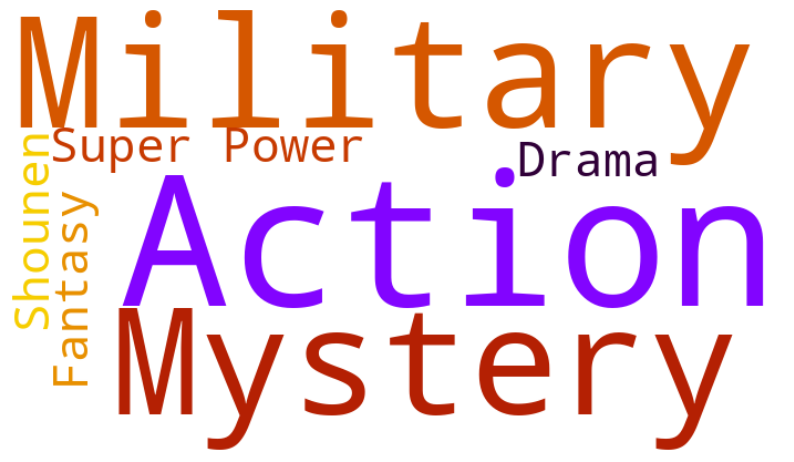

['Action',
 ' Military',
 ' Mystery',
 ' Super Power',
 ' Drama',
 ' Fantasy',
 ' Shounen']

In [71]:
getFavGenre(x, plot = True)

In [ ]:
def get_user_preferences(user_id, rating_data, data, plot = False):
    
    animes_watched_by_user = rating_data[rating_data.user_id == user_id]

    user_rating_percentile = np.percentile(animes_watched_by_user.rating, 75)

    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]

    top_animes_user = (
        animes_watched_by_user.sort_values(by = "rating" , ascending = False).anime_id.values
    )

    anime_df_rows = data[data["anime_id"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["eng_version","Genres"]]

    if plot:
        getFavGenre(anime_df_rows,plot)

    return anime_df_rows
get_user_preferences(11880, df_rating, data_anime, plot = False)

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Ma..."
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, S..."
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Sa..."
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


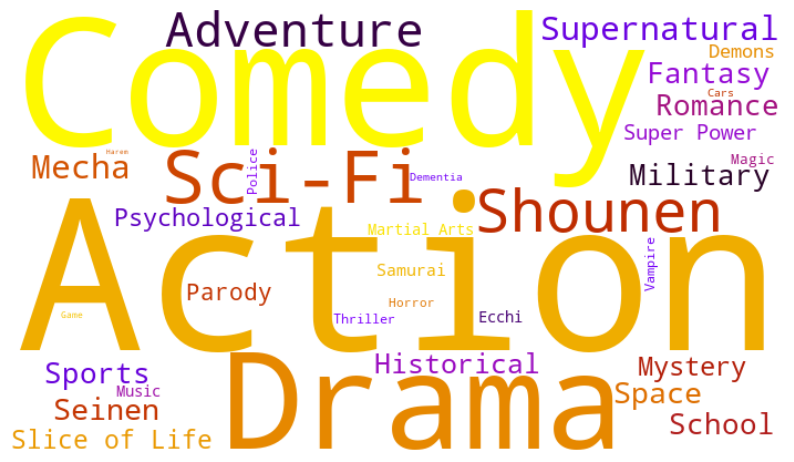

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Ma..."
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, S..."
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Sa..."
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


In [75]:
get_user_preferences(11880, df_rating, data_anime, plot = True)

In [ ]:
def get_user_recommendations(similar_users, user_pref, data, data_synopsis, df_rating, n = 10):
    
    recommended_animes = []
    anime_list = []

    for user_id in similar_users.similar_users.values:
        pref_list = get_user_preferences(int(user_id), df_rating, data)

        pref_list = pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]
        
        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values)

    if anime_list:
            anime_list = pd.DataFrame(anime_list)

            sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)

            for i, anime_name in enumerate(sorted_list.index):
                n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]

                if isinstance(anime_name, str):
                    frame = getAnimeFrame(anime_name, data)
                    anime_id = frame.anime_id.values[0]
                    genre = frame.Genres.values[0]
                    synopsis = getSynopsis(int(anime_id), data_synopsis)

                    recommended_animes.append({
                        "users": n_user_pref,
                        "anime_name": anime_name,
                        "genres": genre,
                        "synopsis": synopsis
                    })
    
    return pd.DataFrame(recommended_animes).head(n)

In [ ]:
similar_users = find_similar_users(int(11880), user_weights, user2user_encoded, user2user_decoded)
user_pref = get_user_preferences(11880, df_rating, data_anime, plot = False)

In [79]:
get_user_recommendations(similar_users, user_pref, data_anime, data_synopsis, df_rating, n = 4)

,users,anime_name,genres,synopsis
0,9,Death Note,"Mystery, Police, Psychological, Supernatural, ...","shinigami, as a god of death, can kill any per..."
1,8,Attack on Titan,"Action, Military, Mystery, Super Power, Drama,...","Centuries ago, mankind was slaughtered to near..."
2,7,Naruto,"Action, Adventure, Comedy, Super Power, Martia...","oments prior to Naruto Uzumaki's birth, a huge..."
3,7,Berserk,"Action, Adventure, Demons, Drama, Fantasy, Hor...","Born from the corpse of his mother, a young me..."


#### Hybrid Recommendation System

In [ ]:
def hybrid_recommendation(user_id, user_weight=0.5, content_weight = 0.5):

    similar_users =find_similar_users(user_id, user_weights, user2user_encoded, user2user_decoded)
    user_pref = get_user_preferences(user_id, df_rating, data_anime)
    user_recommended_animes = get_user_recommendations(similar_users, user_pref, data_anime, data_synopsis, df_rating)
    user_recommended_anime_list = user_recommended_animes["anime_name"].tolist()
    print(user_recommended_anime_list)


    content_recommended_animes = []

    for anime in user_recommended_anime_list:
        similar_animes = find_similar_animes(anime, anime_weights, anime2anime_encoded, anime2anime_decoded, data_anime, data_synopsis)
        if similar_animes is not None and not similar_animes.empty:
            content_recommended_animes.extend(similar_animes["name"].tolist())
        else:
            print(f"No similar anime found {anime}")
    

    combined_scores = {}
    for anime in user_recommended_anime_list:
        combined_scores[anime] = combined_scores.get(anime, 0) + user_weight

    for anime in content_recommended_animes:
        combined_scores[anime] = combined_scores.get(anime, 0) + content_weight  

    sorted_animes = sorted(combined_scores.items() , key = lambda x:x[1] , reverse=True)

    return [anime for anime , score in sorted_animes[:10]] 
hybrid_recommendation(11880)

['Death Note', 'Attack on Titan', 'Naruto', 'Berserk', 'Re:ZERO -Starting Life in Another World-', 'Nisekoi:False Love', 'No Game, No Life', 'Darker than Black', "KonoSuba:God's Blessing on This Wonderful World! 2", 'Spirited Away']
An error occurred: index 0 is out of bounds for axis 0 with size 0
No similar anime found Attack on Titan
An error occurred: index 0 is out of bounds for axis 0 with size 0
No similar anime found Berserk
An error occurred: index 0 is out of bounds for axis 0 with size 0
No similar anime found Darker than Black
An error occurred: index 0 is out of bounds for axis 0 with size 0
No similar anime found KonoSuba:God's Blessing on This Wonderful World! 2
An error occurred: index 0 is out of bounds for axis 0 with size 0
No similar anime found Spirited Away


['New Tokyo Ondo',
 'Death Note',
 'Attack on Titan',
 'Naruto',
 'Berserk',
 'Re:ZERO -Starting Life in Another World-',
 'Nisekoi:False Love',
 'No Game, No Life',
 'Darker than Black',
 "KonoSuba:God's Blessing on This Wonderful World! 2"]